<a href="https://colab.research.google.com/github/sara-ghavampour/10-armed-bandit/blob/main/rl_a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# imports and plotting params
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

np.random.seed(42)


In [12]:
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 10

In [13]:
def plot_results(results, title= "Bandit Results"):
    """Plot experimental results."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    colors = ['blue','red','purple','green','orange']

    # Plot average rewards
    for i, (name, data) in enumerate(results.items()):
        color = colors[i % len(colors)]
        time_steps = range(len(data['avg_rewards']))

        ax1.plot(time_steps, data['avg_rewards'], label=name, color=color, linewidth=2)
        sem = data['std_rewards'] / np.sqrt(1000)
        ax1.fill_between(time_steps,
                        data['avg_rewards'] - sem,
                        data['avg_rewards'] + sem,
                        alpha=0.2, color=color)

    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Average Reward')
    ax1.set_title('Average Reward over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot optimal action percentage
    for i, (name, data) in enumerate(results.items()):
        color = colors[i % len(colors)]
        time_steps = range(len(data['optimal_action_pct']))

        ax2.plot(time_steps, data['optimal_action_pct'], label=name, color=color, linewidth=2)
        sem = data['std_optimal'] / np.sqrt(1000)
        ax2.fill_between(time_steps,
                        data['optimal_action_pct'] - sem,
                        data['optimal_action_pct'] + sem,
                        alpha=0.2, color=color)

    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('% Optimal Action')
    ax2.set_title('Optimal Action Selection over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Simulation functions ready!")

Simulation functions ready!


In [14]:
class Environment:

    def __init__(self, k= 10):
        self.k = k
        #means from N(0,1)
        self.means = np.random.normal(0, 1, k)
        self.optimal_action = np.argmax(self.means)
        # print(f"Environment created with means: {self.true_means}")
        # print(f"Optimal action: {self.optimal_action} (mean: {self.true_means[self.optimal_action]:.3f})")

    def get_reward(self,action):

        return np.random.normal(self.means[action], 1)

    def reset_means(self, new_means):

        self.means = new_means.copy()
        self.optimal_action = np.argmax(self.means)

In [15]:
class GreedyAgent:

    def __init__(self, k, initial_values= 0.0):
        self.k = k
        self.initial_values = initial_values
        self.reset()

    def reset(self):
        self.q_values = np.full(self.k, self.initial_values)
        self.action_counts = np.zeros(self.k)

    def select_action(self):
        max_value = np.max(self.q_values)
        best_actions = np.where(self.q_values == max_value)[0]

        # tie breaking at random
        return np.random.choice(best_actions)

    def update(self, action, reward):

      #incremental updates of Q(a)
        self.action_counts[action]+=1
        step_size = 1.0 / self.action_counts[action]
        self.q_values[action]+=step_size*(reward-self.q_values[action])

In [16]:
class EpsilonGreedyAgent:

    def __init__(self, k,epsilon,initial_values=0.0):
        self.k = k
        self.epsilon = epsilon
        self.initial_values = initial_values
        self.reset()

    def reset(self):
        self.q_values = np.full(self.k, self.initial_values)
        self.action_counts = np.zeros(self.k)


    def select_action(self):
       # Explore
        if np.random.random() < self.epsilon:
            return np.random.randint(self.k)
        # Exploit
        else:
            max_value = np.max(self.q_values)
            best_actions = np.where(self.q_values == max_value)[0]
            return np.random.choice(best_actions)

    def update(self,a,reward):
        self.action_counts[a] += 1
        step_size = 1.0 / self.action_counts[a]
        self.q_values[a] += step_size * (reward - self.q_values[a])

In [17]:
class OptimisticGreedyAgent:

    def __init__(self,k,means):
        self.k = k
        max_mean = np.max(means)

        # 99.5th percentile of N(max_mean, 1)
        self.initial_values = max_mean + 2.576
        # print(f"Optimistic initial value: {self.initial_values:.3f}")
        self.reset()

    def reset(self):
        self.q_values = np.full(self.k, self.initial_values)
        self.action_counts = np.zeros(self.k)

    def select_action(self):
        max_value = np.max(self.q_values)
        best_actions = np.where(self.q_values == max_value)[0]
        return np.random.choice(best_actions)

    def update(self, action: int, reward: float):
        self.action_counts[action] += 1
        step_size = 1.0 / self.action_counts[action]
        self.q_values[action] += step_size * (reward - self.q_values[action])

In [18]:

class GradientBanditAgent:

    def __init__(self,k,alpha):
        self.k = k
        self.alpha = alpha
        self.reset()

    def reset(self):

        self.preferences = np.zeros(self.k)
        self.average_reward = 0.0
        self.step = 0

    def get_action_probabilities(self) :
        exp_prefs = np.exp(self.preferences - np.max(self.preferences))  # Numerical stability
        return exp_prefs / np.sum(exp_prefs)

    def select_action(self):
        probs = self.get_action_probabilities()
        return np.random.choice(self.k, p=probs)

    def update(self,action,reward):
        # Update average reward (baseline) - this is R̄_t
        self.step += 1
        self.average_reward += (reward - self.average_reward) / self.step

        # Get action probabilities π_t(a) = e^H_t(a) / Σ_k e^H_t(k)
        probs = self.get_action_probabilities()

        # Calculate baseline: (R_t - R̄_t)
        baseline = reward - self.average_reward

        # Update preferences according to gradient bandit formulas:
        # For all actions a ≠ A_t: H_{t+1}(a) = H_t(a) - α(R_t - R̄_t)π_t(a)
        self.preferences -= self.alpha * baseline * probs

        # For chosen action A_t: H_{t+1}(A_t) = H_t(A_t) + α(R_t - R̄_t)(1 - π_t(A_t))
        # This is equivalent to: H_t(A_t) - α(R_t - R̄_t)π_t(A_t) + α(R_t - R̄_t)
        self.preferences[action] += self.alpha * baseline

In [19]:
def find_optimal_epsilon():

    epsilons= [0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
    _runs=200
    T= 1000
    best_epsilon = 0.1
    best_reward = -float('inf')

    for eps in epsilons:
        config = {
            'eps_greedy': {
                'class': EpsilonGreedyAgent,
                'params': {'k': 10, 'epsilon': eps}
            }
        }

        results = run_experiment(config, num_simulations=_runs, T=T)
        avg_reward = np.mean(results['eps_greedy']['avg_rewards'][-200:])
        print(f"  ε = {eps}: avg reward = {avg_reward:.3f}")

        if avg_reward > best_reward:
            best_reward = avg_reward
            best_eps = eps

    print(f"Best epsilon: {best_epsilon}")
    return best_epsilon

def find_optimal_alpha():

    print("Finding optimal alpha...")
    alphas= [0.05, 0.1, 0.15, 0.2, 0.3, 0.4]
    _runs= 200
    T= 1000
    best_alpha = 0.1
    best_reward = -float('inf')

    for alpha in alphas:
        config = {
            'gradient': {
                'class': GradientBanditAgent,
                'params': {'k': 10, 'alpha': alpha}
            }
        }

        results = run_experiment(config, num_simulations=_runs, T=T)
        #valuate algorithms based on their final performance rather than their entire learning curve
        # simply using avg_reward = np.mean(rewards) would penalize algorithms that start poorly but learn well, and favor algorithms that start well but plateau.
        avg_reward = np.mean(results['gradient']['avg_rewards'][-200:])
        print(f"  α = {alpha}: avg reward = {avg_reward:.3f}")

        if avg_reward > best_reward:
            best_reward = avg_reward
            best_alpha = alpha


    print(f"Best alpha: {best_alpha}")
    return best_alpha

In [20]:
def run_single_simulation(agent,env,T= 2000,mode= 'stationary',noise_seed= None,perm_seed= None):


    if mode in ['drift', 'mean_revert'] and noise_seed is not None:

        np.random.seed(noise_seed)
        # list of random number generators — one for each arm
        noise_generators = [np.random.RandomState(noise_seed + i) for i in range(env.k)]
        # reset the RNG back to a non-deterministic state so that
        # future random operations aren't affected by the fixed seed used earlier.
        np.random.seed()

    rewards = []
    actions = []
    optimal_actions = []
    current_means = env.means.copy()

    for t in range(T):
        # Handle non-stationary scenarios
        if mode == 'drift' and t != 0:
            for i in range(env.k):
                noise = noise_generators[i].normal(0, 0.01)
                current_means[i] += noise
            env.reset_means(current_means)

        elif mode == 'mean_revert' and t != 0:
            for i in range(env.k):
                noise = noise_generators[i].normal(0, 0.01)
                # mean_revert 0.5
                current_means[i] = 0.5 * current_means[i] + noise
            env.reset_means(current_means)

        elif mode == 'abrupt' and t == 500:
            if perm_seed is not None:
                np.random.seed(perm_seed)
            # randomly rearranging the means across arms.
            perm = np.random.permutation(env.k)
            current_means = current_means[perm]
            env.reset_means(current_means)
            np.random.seed()

        elif mode == 'hard_reset' and t == 500:
            if perm_seed is not None:
                np.random.seed(perm_seed)
            perm = np.random.permutation(env.k)
            current_means = current_means[perm]
            env.reset_means(current_means)
            agent.reset()
            np.random.seed()

        # Record optimal action and get agent's action
        optimal_actions.append(env.optimal_action)
        action = agent.select_action()
        reward = env.get_reward(action)
        agent.update(action, reward)

        actions.append(action)
        rewards.append(reward)

    return rewards, actions, optimal_actions

In [21]:
def run_experiment(agent_configs,num_simulations= 1000, T= 2000,scenario='stationary'):

    # Generate consistent seeds
    #initialize the NumPy random number at the beginning for reproducibility
    master_seed = 12345
    np.random.seed(master_seed)
    # for gradual changes
    noise_seeds = np.random.randint(0, 1000000, 10)
    # abrupt changes
    perm_seed = np.random.randint(0, 1000000)
    # for controlled ramdomness and reproducibility
    simulation_seeds = np.random.randint(0, 1000000, num_simulations)
    np.random.seed()

    results = {}

    for agent_name, config in agent_configs.items():
        print(f"Running {agent_name}...")

        all_rewards = []
        all_optimal_actions = []

        for sim in range(num_simulations):
            np.random.seed(simulation_seeds[sim])
            env = Environment()

            if config['class'] == OptimisticGreedyAgent:
                agent = config['class'](10, env.means)
            else:
                agent = config['class'](**config['params'])

                # generated 10 noise seeds but running 1000 simulations
            rewards, actions, optimal_actions = run_single_simulation(
                agent, env, T, scenario,
                noise_seed=noise_seeds[sim % 10] if scenario in ['drift', 'mean_revert'] else None,
                perm_seed=perm_seed
            )

            all_rewards.append(rewards)
            #have a list of binary arrays to further calcuulate percentage of choosing the optimal action
            optimal_mask = [1 if actions[i] == optimal_actions[i] else 0 for i in range(len(actions))]
            all_optimal_actions.append(optimal_mask)

        all_rewards = np.array(all_rewards)
        all_optimal_actions = np.array(all_optimal_actions)


        #last 2 items for plotting
        results[agent_name] = {
            'avg_rewards': np.mean(all_rewards, axis=0),
            'optimal_action_pct': np.mean(all_optimal_actions, axis=0) * 100,
            'std_rewards': np.std(all_rewards, axis=0),
            'std_optimal': np.std(all_optimal_actions, axis=0) * 100
        }

    return results

In [22]:
# Run hyperparameter tuning
print("hyperparameter tuning...")
optimal_epsilon = find_optimal_epsilon()
optimal_alpha = find_optimal_alpha()

print(f"\n hyperparameters found:")
print(f"ε = {optimal_epsilon}")
print(f"α = {optimal_alpha}")

hyperparameter tuning...
Running eps_greedy...
  ε = 0.01: avg reward = 1.377
Running eps_greedy...
  ε = 0.05: avg reward = 1.465
Running eps_greedy...
  ε = 0.1: avg reward = 1.404
Running eps_greedy...
  ε = 0.15: avg reward = 1.335
Running eps_greedy...
  ε = 0.2: avg reward = 1.265
Running eps_greedy...
  ε = 0.3: avg reward = 1.106
Best epsilon: 0.1
Finding optimal alpha...
Running gradient...
  α = 0.05: avg reward = 1.527
Running gradient...
  α = 0.1: avg reward = 1.541
Running gradient...
  α = 0.15: avg reward = 1.528
Running gradient...
  α = 0.2: avg reward = 1.521
Running gradient...
  α = 0.3: avg reward = 1.489
Running gradient...
  α = 0.4: avg reward = 1.480
Best alpha: 0.1

 hyperparameters found:
ε = 0.1
α = 0.1


Q1: stattionary results
Running Greedy (Q₀=0)...
Running ε-Greedy (ε=0.1)...
Running Optimistic Greedy...
Running Gradient Bandit (α=0.1)...


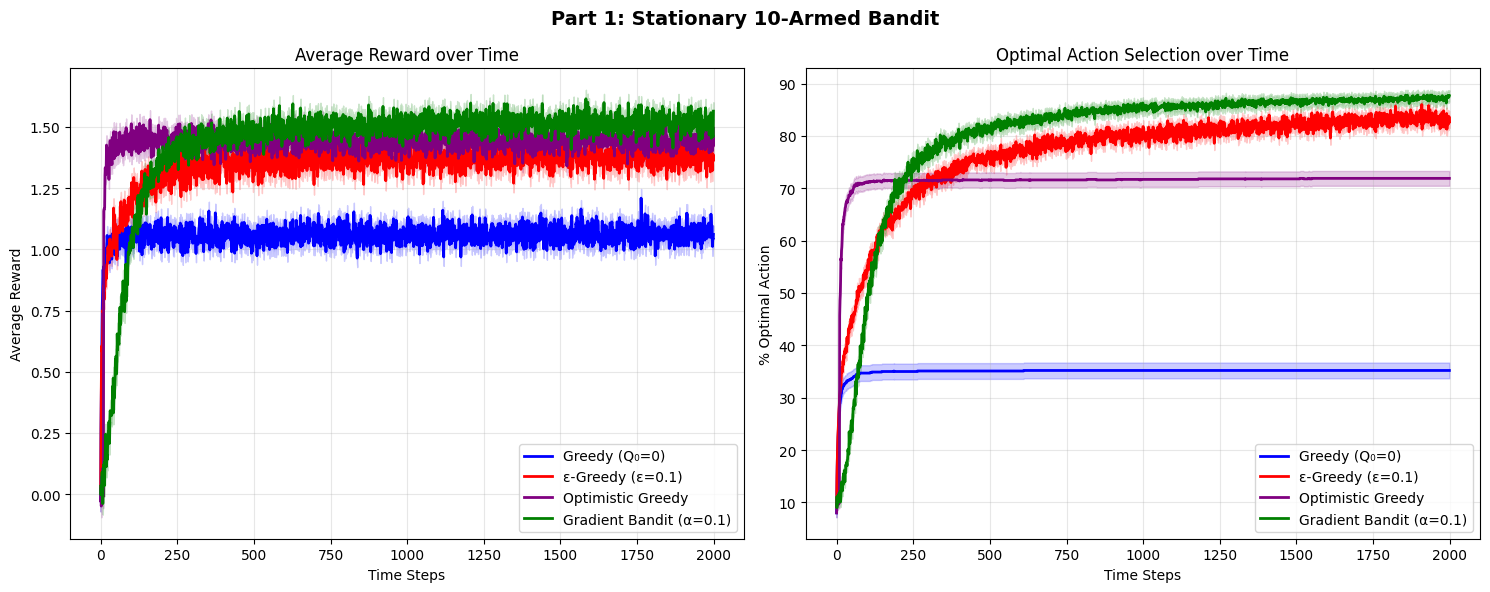

In [23]:
#  Part 1: Stationary problem


# 2000 time steps
#1000 simulations
print("Q1: stattionary results")





agent_configs_part1 = {
    'Greedy (Q₀=0)': {
        'class': GreedyAgent,
        'params': {'k': 10, 'initial_values': 0.0}
    },
    f'ε-Greedy (ε={optimal_epsilon})': {
        'class': EpsilonGreedyAgent,
        'params': {'k': 10, 'epsilon': optimal_epsilon}
    },
    'Optimistic Greedy': {
        'class': OptimisticGreedyAgent,
        'params': {}
    },
    f'Gradient Bandit (α={optimal_alpha})': {
        'class': GradientBanditAgent,
        'params': {'k': 10, 'alpha': optimal_alpha}
    }
}


results_part1 = run_experiment(agent_configs_part1, scenario='stationary')


plot_results(results_part1, "Part 1: Stationary 10-Armed Bandit")





In [24]:

print("Summary results for part 1")
print("*****************************************************************")


for agent_name, result in results_part1.items():
    final_reward = result['avg_rewards'][-1]
    final_optimal_pct = result['optimal_action_pct'][-1]
    final_100_avg = np.mean(result['avg_rewards'][-100:])


    print(f"{agent_name} results in part 1: ")
    print(f"final_reward: {final_reward}")
    print(f"final_optimal_pct: {final_optimal_pct}")
    print(f"final_100_avg: {final_100_avg}")



Summary results for part 1
*****************************************************************
Greedy (Q₀=0) results in part 1: 
final_reward: 1.0609804280043869
final_optimal_pct: 35.199999999999996
final_100_avg: 1.0671609103001314
ε-Greedy (ε=0.1) results in part 1: 
final_reward: 1.3653111068429113
final_optimal_pct: 82.69999999999999
final_100_avg: 1.3795619759548767
Optimistic Greedy results in part 1: 
final_reward: 1.4945644566392362
final_optimal_pct: 71.89999999999999
final_100_avg: 1.4463852764827374
Gradient Bandit (α=0.1) results in part 1: 
final_reward: 1.5643571473005342
final_optimal_pct: 87.7
final_100_avg: 1.5140190740615131


PART 2: NON-STATIONARY BANDIT
********************************8
Drift Scenario
Running ε-Greedy (ε=0.1)...
Running Gradient Bandit (α=0.1)...


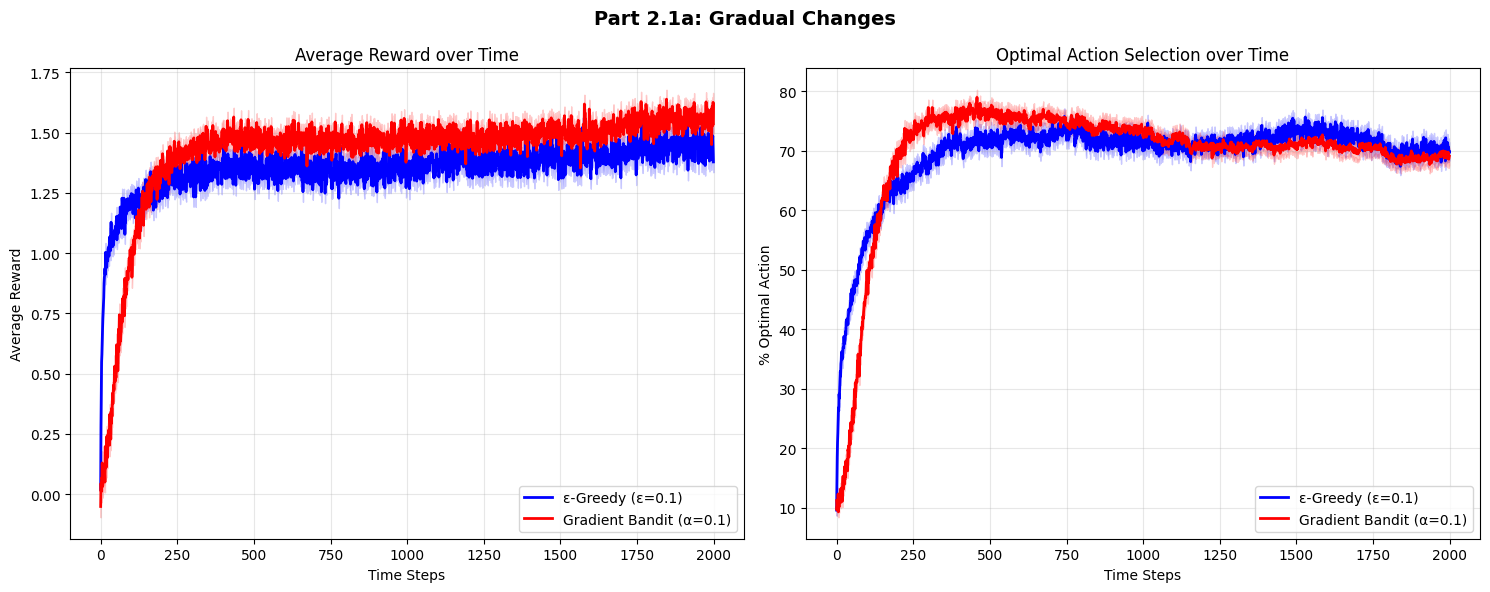

2.1b: Mean Reversion 
Running ε-Greedy (ε=0.1)...
Running Gradient Bandit (α=0.1)...


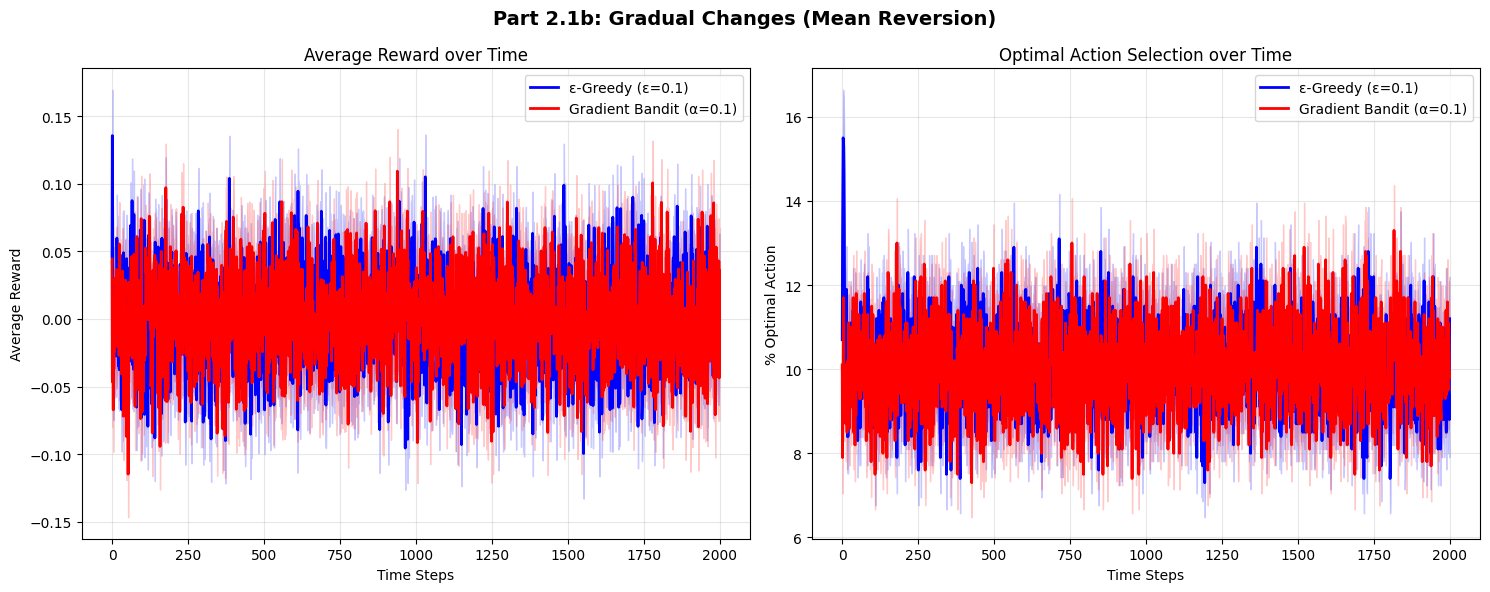

Abrupt Changes at t=501
Running ε-Greedy (ε=0.1)...
Running Gradient Bandit (α=0.1)...


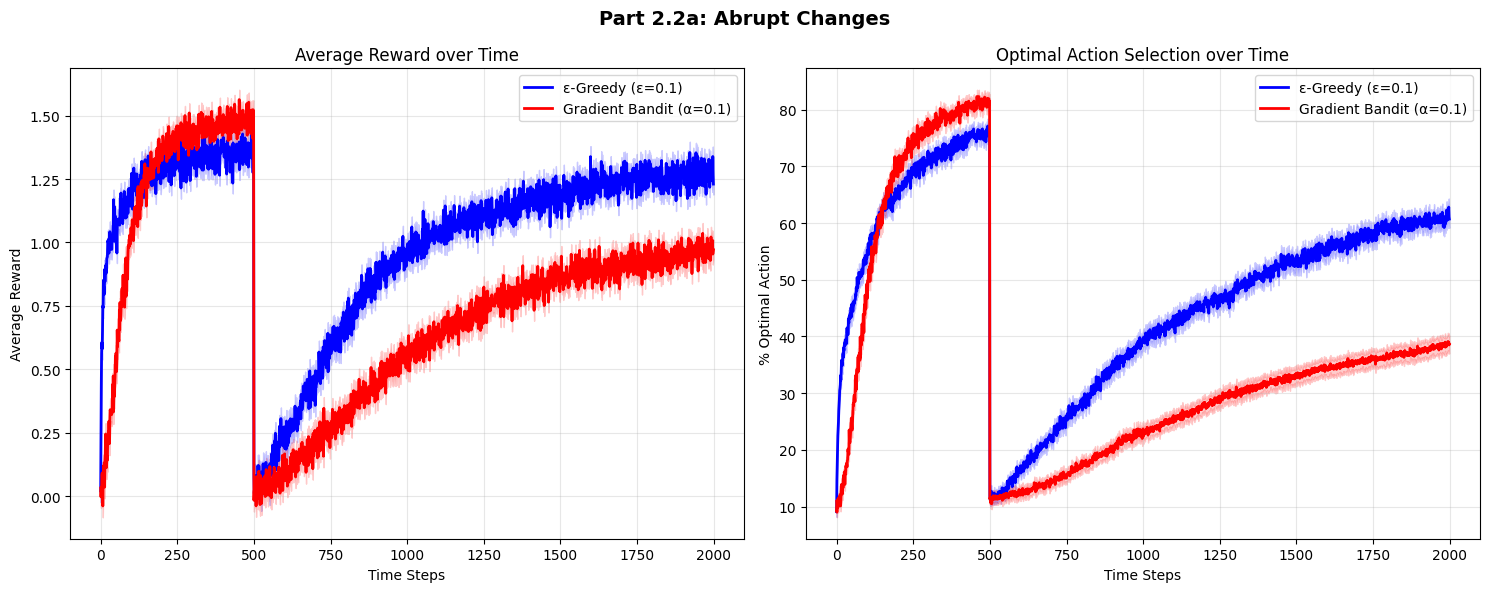

2.2b: Abrupt Changes ( Hard Reset)
Running ε-Greedy (ε=0.1)...
Running Gradient Bandit (α=0.1)...


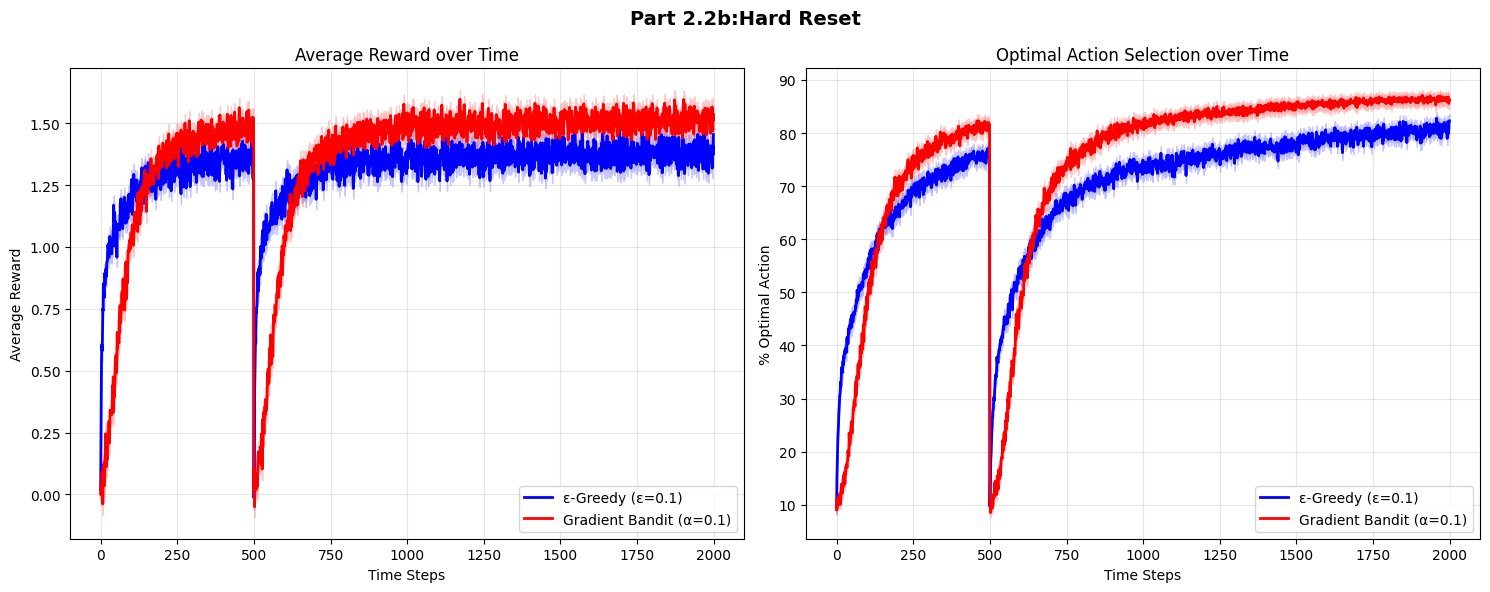

In [25]:

# # Part 2: Non-stationary Bandit Problems




print("PART 2: NON-STATIONARY BANDIT")
print("********************************8")

# For Part 2, compare action-value methods with gradient bandit
agent_configs_part2 = {
    f'ε-Greedy (ε={optimal_epsilon})': {
        'class': EpsilonGreedyAgent,
        'params': {'k': 10, 'epsilon': optimal_epsilon}
    },
    f'Gradient Bandit (α={optimal_alpha})': {
        'class': GradientBanditAgent,
        'params': {'k': 10, 'alpha': optimal_alpha}
    }
}

# Part 2.1a: Drift


print("Drift Scenario")


results_drift = run_experiment(agent_configs_part2, scenario='drift')
plot_results(results_drift, "Part 2.1a: Gradual Changes")

# ## Part 2.1b: Mean Reversion


print("2.1b: Mean Reversion ")


results_mean_revert = run_experiment(agent_configs_part2, scenario='mean_revert')
plot_results(results_mean_revert, "Part 2.1b: Gradual Changes (Mean Reversion)")


#  Part 2.2a: Abrupt Changes


print("Abrupt Changes at t=501")


results_abrupt = run_experiment(agent_configs_part2, scenario='abrupt')
plot_results(results_abrupt, "Part 2.2a: Abrupt Changes")


# ## Part 2.2b: Abrupt Changes - Hard Reset


print("2.2b: Abrupt Changes ( Hard Reset)")

results_abrupt_reset = run_experiment(agent_configs_part2, scenario='hard_reset')
plot_results(results_abrupt_reset, "Part 2.2b:Hard Reset")




In [31]:
# # Final Analysis and Summary


print("************************************")


all_results = {
    'Stationary': results_part1,
    'Drift': results_drift,
    'Mean Reversion': results_mean_revert,
    'Abrupt': results_abrupt,
    'Abrupt + Reset': results_abrupt_reset
}

print(f"{'Scenario':<20} {'Algorithm':<25} {'Final Reward':<15} {'Optimal %':<15}")
print("-" * 75)

for scenario_name, results in all_results.items():
    for i, (agent_name, data) in enumerate(results.items()):
        final_optimal = np.mean(data['optimal_action_pct'][-100:])

        scenario_label = scenario_name if i == 0 else ""
        print(f"scenario_name: {scenario_name}")
        print(f"agent_name: {agent_name}")
        print(f"final_reward: {final_reward}")
        print(f"final_optimal_pct: {final_optimal_pct}")
        print(f"final_100_avg: {final_100_avg}")
        print("_____________________________________________________________")


************************************
Scenario             Algorithm                 Final Reward    Optimal %      
---------------------------------------------------------------------------
scenario_name: Stationary
agent_name: Greedy (Q₀=0)
final_reward: 1.5643571473005342
final_optimal_pct: 87.7
final_100_avg: 1.5140190740615131
_____________________________________________________________
scenario_name: Stationary
agent_name: ε-Greedy (ε=0.1)
final_reward: 1.5643571473005342
final_optimal_pct: 87.7
final_100_avg: 1.5140190740615131
_____________________________________________________________
scenario_name: Stationary
agent_name: Optimistic Greedy
final_reward: 1.5643571473005342
final_optimal_pct: 87.7
final_100_avg: 1.5140190740615131
_____________________________________________________________
scenario_name: Stationary
agent_name: Gradient Bandit (α=0.1)
final_reward: 1.5643571473005342
final_optimal_pct: 87.7
final_100_avg: 1.5140190740615131
_________________________________